In [1]:
import numpy as np
import matplotlib as plt
import pandas as pd
import scipy as sp
import sklearn
import xgboost as xgb
import shap
import lime
import lime.lime_tabular
from sklearn.metrics import accuracy_score
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

shap.initjs()

In [2]:
adult=pd.read_csv('adult.csv')
print("Dataset abstract: predict whether income exceeds $50K/yr based on census data.")

print('Shape before deleting duplicate values:', adult.shape)
adulte=adult.drop_duplicates()
print('Shape after deleting duplicate values:', adult.shape)

adult.head(10)

Dataset abstract: predict whether income exceeds $50K/yr based on census data.
Shape before deleting duplicate values: (48842, 15)
Shape after deleting duplicate values: (48842, 15)


age  workclass  fnlwgt  education  educational-num  marital-status  \
0   25          4  226802          1                7               4   
1   38          4   89814         11                9               2   
2   28          2  336951          7               12               2   
3   44          4  160323         15               10               2   
4   18          0  103497         15               10               4   
5   34          4  198693          0                6               4   
6   29          0  227026         11                9               4   
7   63          6  104626         14               15               2   
8   24          4  369667         15               10               4   
9   55          4  104996          5                4               2   

   occupation  relationship  race  gender  capital-gain  capital-loss  \
0           7             3     2       1             0             0   
1           5             0     4       1             0             0   
2          11             0     4       1             0             0   
3           7             0     2       1          7688             0   
4           0             3     4       0             0             0   
5           8             1     4       1             0             0   
6           0             4     2       1             0             0   
7          10             0     4       1          3103             0   
8           8             4     4       0             0             0   
9           3             0     4       1             0             0   

   hours-per-week  native-country  income  
0              40              39       0  
1              50              39       0  
2              40              39       1  
3              40              39       1  
4              30              39       0  
5              30              39       0  
6              40              39       0  
7              32              39       1  
8              40              39       0  
9              10              39       0

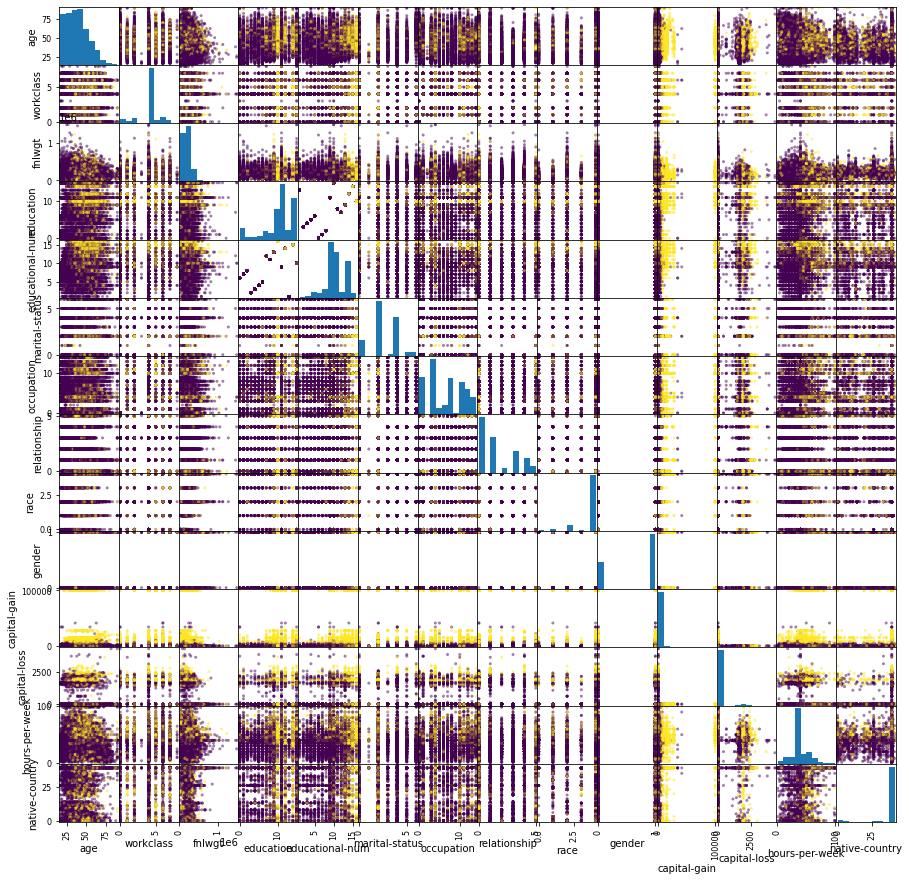

In [68]:
Predictors=['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
TargetVariable = 'income'

from sklearn.model_selection import train_test_split
X = adult[features]
y = adult[target]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

adult_dataframe = pd.DataFrame(X_train, columns=features)
grr = pd.plotting.scatter_matrix(adult_dataframe, c=y_train, figsize=(15,15),marker='.')

<AxesSubplot:xlabel='income'>

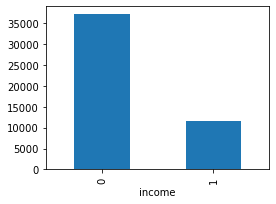

In [4]:
GroupedData = adult.groupby(target).size()
GroupedData.plot(kind = 'bar', figsize = (4,3))

In [71]:
X = np.array(X)
X_train = np.array(X_train)
X_test = np.array(X_test)
y = np.array(y)
y_train = np.array(y_train)
y_test = np.array(y_test)

xgb_model = xgb.XGBClassifier(n_estimators = 100,random_state=0)
xgb_model.fit(X_train, y_train)
print(xgb_model.score(X_train,y_train))
xgb_model.score(X_test,y_test)

0.9004668177226939


0.8725739087707804

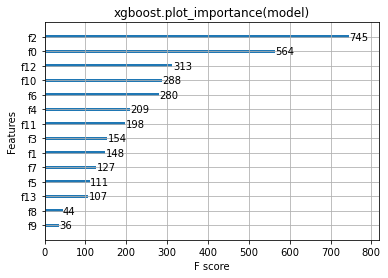

In [53]:
xgb.plot_importance(xgb_model)
pl.title("xgboost.plot_importance(model)")
pl.show()

In [54]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
np.shape(shap_values)

(48842, 14)

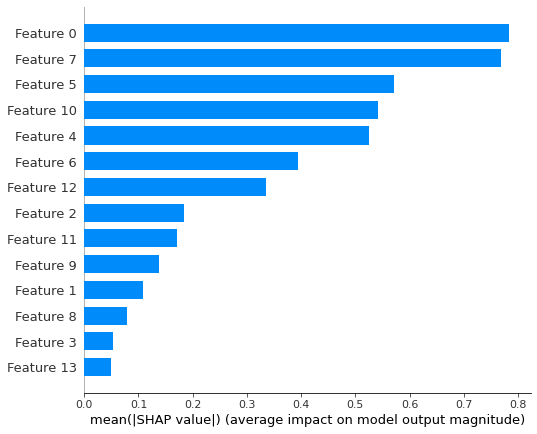

In [55]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [56]:
shap.force_plot(explainer.expected_value, shap_values[:1000], X[:1000])

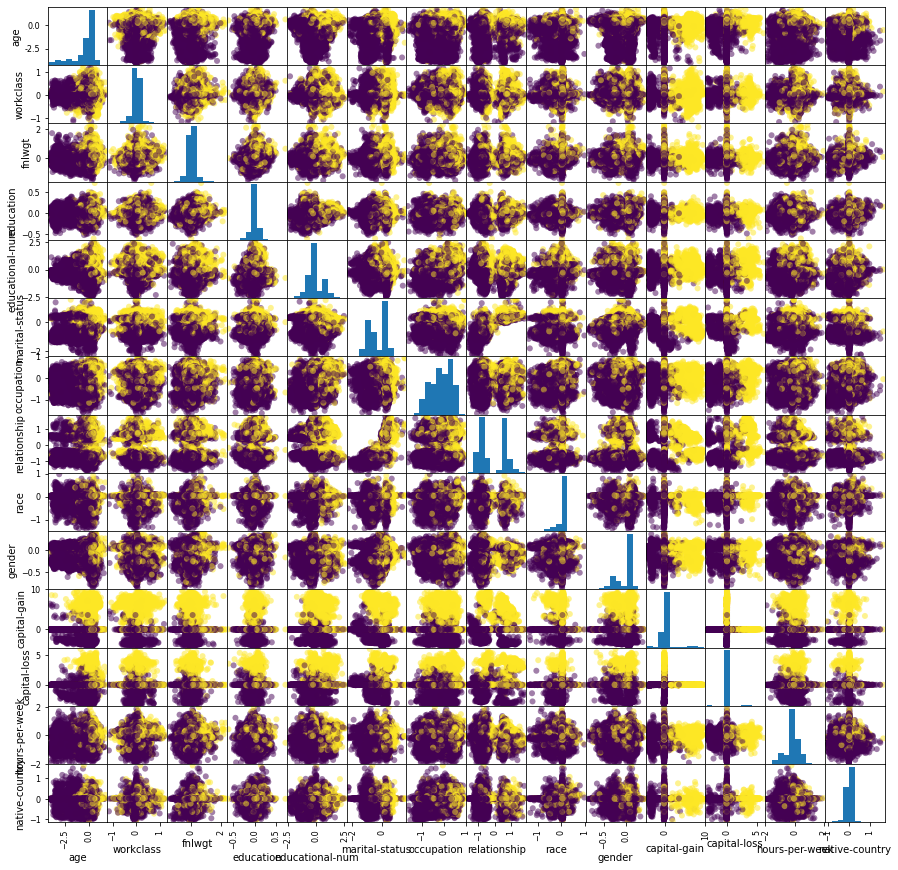

In [57]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

shap_dataframe = pd.DataFrame(shap_values, columns=features)
shap_data = shap_values.astype(np.double)
pd.plotting.scatter_matrix(shap_dataframe, c=y, figsize=(15,15),marker='o')
plt.show()

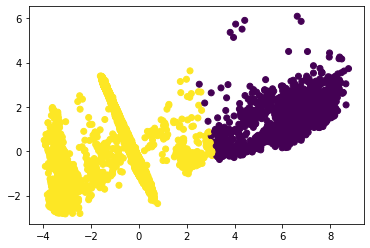

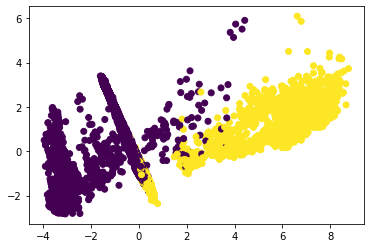

In [58]:
model = KMeans(n_clusters=2,random_state=0)
model.fit(shap_data)

cat = model.predict(shap_data)
clusters = np.unique(cat)

dims = PCA(n_components=2).fit_transform(shap_data)
dims = pd.DataFrame(dims,columns=['PC1','PC2'])

plt.scatter(dims['PC1'],dims['PC2'],c=model.predict(shap_data))
plt.show()
plt.scatter(dims['PC1'],dims['PC2'],c=y)

In [59]:
from scipy.stats.stats import pearsonr     
print(pearsonr(model.predict(shap_data),y))

(-0.3982807219752977, 0.0)


In [63]:
lime_values = np.zeros((1000,14))

explainer = lime.lime_tabular.LimeTabularExplainer(X, verbose=True, mode='classification')

for i in range(1000):
    exp = explainer.explain_instance(X[i], xgb_model.predict_proba, num_features=14)
    _,lime_values_ = list(zip(*exp.as_list()))
    lime_values_ = np.array(lime_values_)
    lime_values[i] = lime_values_

Intercept 1.0585076683776455
Prediction_local [-0.1087958]
Right: 0.0010165815
Intercept 0.7309062900083975
Prediction_local [0.27026242]
Right: 0.22724102
Intercept 0.8554491935849645
Prediction_local [0.11967026]
Right: 0.38610092
Intercept 0.2492131453610427
Prediction_local [0.94025832]
Right: 0.9992975
Intercept 1.0283283187959604
Prediction_local [-0.07164125]
Right: 0.00018896602
Intercept 0.9044336238801345
Prediction_local [-0.07204009]
Right: 0.0028428056
Intercept 1.0444515804575127
Prediction_local [-0.00114136]
Right: 0.0011648174
Intercept 0.1676203976532483
Prediction_local [1.00436102]
Right: 0.98457724
Intercept 0.9869931310005376
Prediction_local [-0.0487172]
Right: 0.002455983
Intercept 0.8954260991454285
Prediction_local [0.13452409]
Right: 0.04042098
Intercept 0.18459402538487735
Prediction_local [0.85917598]
Right: 0.97074133
Intercept 0.869793559587276
Prediction_local [0.22985588]
Right: 0.561785
Intercept 1.018563821754421
Prediction_local [-0.11785906]
Right: 

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.


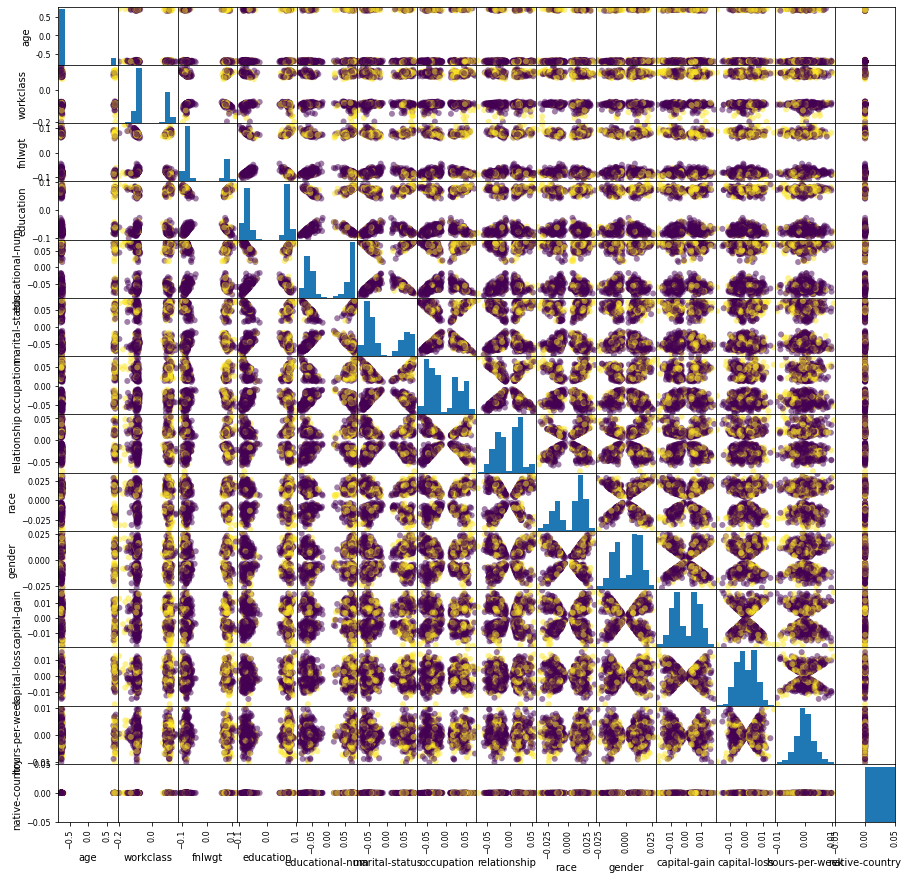

In [72]:
lime_dataframe = pd.DataFrame(lime_values, columns=features)
lime_data = lime_values.astype(np.double)
pd.plotting.scatter_matrix(lime_dataframe, c=y[:1000], figsize=(15,15),marker='o')
plt.show()

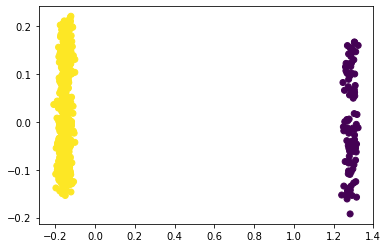

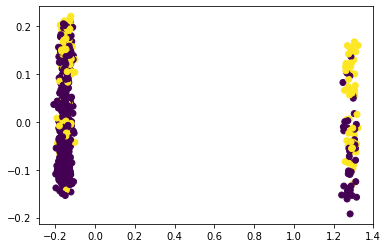

In [73]:
model = KMeans(n_clusters=2,random_state=0)
model.fit(lime_data)

cat = model.predict(lime_data)
clusters = np.unique(cat)

dims = PCA(n_components=2).fit_transform(lime_data)
dims = pd.DataFrame(dims,columns=['PC1','PC2'])

plt.scatter(dims['PC1'],dims['PC2'],c=model.predict(lime_data))
plt.show()
plt.scatter(dims['PC1'],dims['PC2'],c=y[:1000])

In [74]:
print(pearsonr(model.predict(lime_data),y[:1000]))

(-0.25816544728049695, 1.0885447310220735e-16)
